In [1]:
from __future__ import print_function, division
import sys
sys.path.append('../src')
sys.path.append('../script')

import numpy as np
import time
import torch
import pickle
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.nn import Parameter
from data_classes import RNASeqDataset, LocalEnergyOpt, LocalEnergy
from my_script import get_target, loss_fn, train, test
from sklearn import decomposition, manifold
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import math
from cmath import rect, phase
# plt.style.use('bmh')

from matplotlib import rc
plt.style.use('default')
plt.rcParams["font.family"] = "serif"
rc('text.latex', preamble=r'\usepackage{cmbright}')

In [4]:
# CUDA for Pytorch
# print(torch.cuda.is_available())
# device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device ='cpu'

In [5]:
seq_data = RNASeqDataset(device=device)
print(f'dataset allocated on {device}')
lengths = torch.zeros(len(seq_data),10).long()
features = torch.zeros(len(seq_data),445,10)
for i in range(len(seq_data)):
    lengths[i] = seq_data[i]['lengths']
    features[i] = seq_data[i]['features']
# lengths = np.array(lengths)
print(lengths.shape, features.shape)

dataset allocated on cpu
torch.Size([1635, 10]) torch.Size([1635, 445, 10])


## Occurrence of bond types

In [4]:
bt_dict = {classname: 0 for classname in np.arange(0,11)}
btypes = features[:,:,6].squeeze().long()
for i in range(len(seq_data)):
    bt = (btypes[i,:lengths[i,6].squeeze()]-1).view(-1,3)[:,2]
    for label in bt:
        bt_dict[label.item()] += 1
print(list(bt_dict.values()))

[9810, 11445, 3425, 2595, 2554, 2871, 3425, 2595, 11445, 9810, 11445]


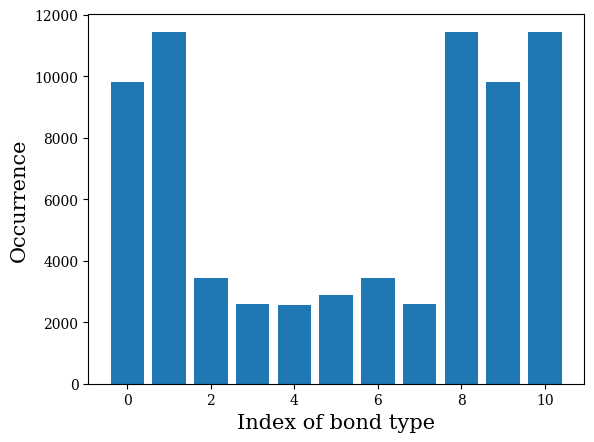

In [5]:
b_occ = plt.bar(list(bt_dict.keys()),height=list(bt_dict.values()))
plt.xlabel('Index of bond type',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('../Images/bonds_occurr.pdf')
plt.show()

### Data visualzation

In [6]:
# One-hot encoding
labels = range(1,12)
lb = LabelBinarizer()
lb.fit(labels)

b_maxlen = int(max(lengths[:,6])/3)
Xb = torch.zeros(len(seq_data),b_maxlen*11)
for i in range(len(seq_data)):
    Xb[i,:int(lengths[i,6]/3)*11] = torch.from_numpy(lb.transform(btypes[i,:lengths[i,6].squeeze()].view(-1,3)[:,2]).reshape(-1,))
print(Xb.shape)

torch.Size([1635, 517])


PC1 variance fraction explained = 0.18158349248025393
PC2 variance fraction explained = 0.12080302892263042


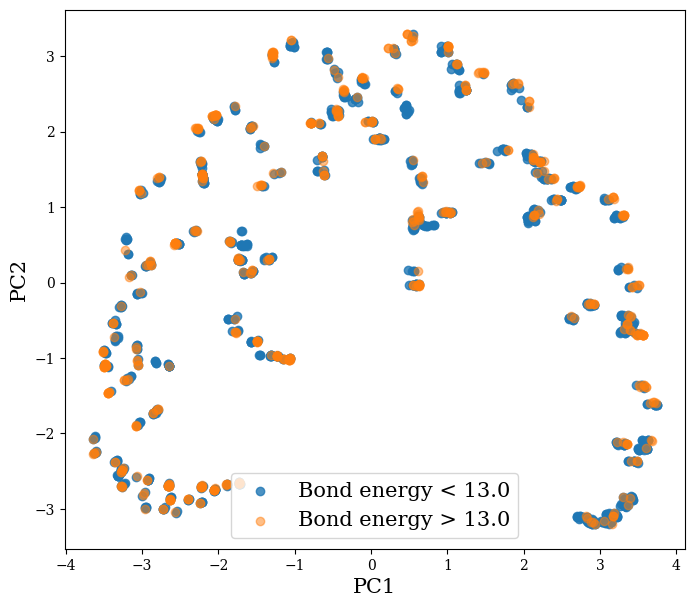

In [7]:
# PCA
pca = decomposition.PCA()
Xb_pca = pca.fit_transform(Xb)
varb = pca.explained_variance_ratio_
print(f"PC1 variance fraction explained = {varb[0]}")
print(f"PC2 variance fraction explained = {varb[1]}")
fig = plt.figure(figsize=(8,7))
plt.scatter(Xb_pca[features[:,0,9]<13,0],Xb_pca[features[:,0,9]<13,1],alpha=0.8,label='Bond energy < 13.0')
plt.scatter(Xb_pca[features[:,0,9]>=13,0],Xb_pca[features[:,0,9]>=13,1],alpha=0.5,label='Bond energy > 13.0')
plt.xlabel("PC1", fontsize=15)
plt.ylabel("PC2", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('../Images/bondsPCA.pdf')
plt.show()

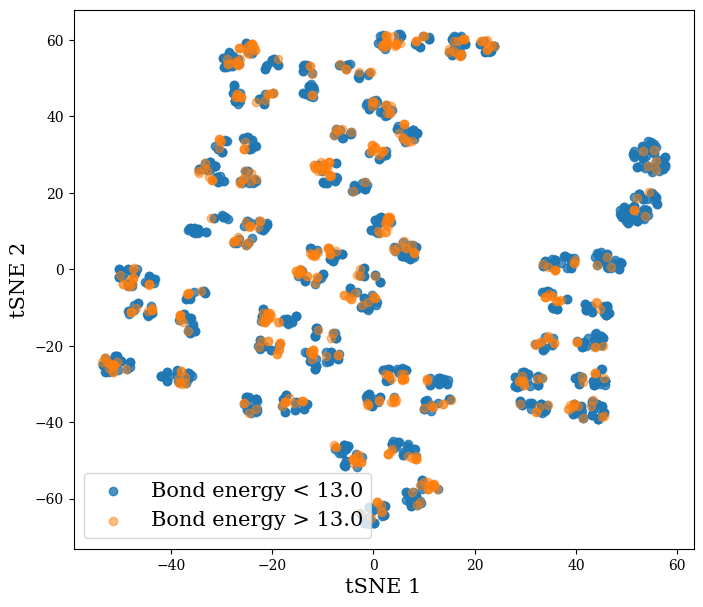

In [8]:
# t-SNE
Xb_tSNE = manifold.TSNE().fit_transform(Xb)
fig = plt.figure(figsize=(8,7))
plt.scatter(Xb_tSNE[features[:,0,9]<13,0],Xb_tSNE[features[:,0,9]<13,1],alpha=0.8,label='Bond energy < 13.0')
plt.scatter(Xb_tSNE[features[:,0,9]>=13,0],Xb_tSNE[features[:,0,9]>=13,1],alpha=0.5,label='Bond energy > 13.0')
plt.xlabel("tSNE 1", fontsize=15)
plt.ylabel("tSNE 2", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('../Images/bondsTSNE.pdf')
plt.show()

### check if more divergent results show some particular distribution of bond types

In [9]:
fixed_pars = pickle.load(open('../data/SeqCSV/fixed_pars.p', 'rb'))
opt_pars = pickle.load(open('../data/SeqCSV/pars.p', 'rb'))
model = LocalEnergyOpt(fixed_pars,opt_pars,device).to(device)
model.load_state_dict(torch.load("../data/Results/250_0.pth"))

for p in model.parameters():
    print(p)

Parameter containing:
tensor([2.1357e-01, 2.0810e+00, 1.5191e+00, 2.3544e+00, 4.1974e+00, 4.5878e+00,
        4.7566e+00, 5.5238e+00, 2.0957e+00, 1.4609e+00, 1.5223e+01, 1.0000e+00,
        2.8000e+00, 2.5050e+00, 1.8260e+00, 3.9320e+00, 4.3090e+00, 4.7750e+00,
        4.5460e+00, 2.8210e+00, 3.8130e+00, 3.0100e+00, 9.0800e-01, 3.0000e+00,
        4.0000e+00, 2.2570e+00, 4.8000e-01, 5.0000e-01, 4.5501e+00, 1.0791e+01,
        1.1136e+01, 5.5788e+00, 2.8008e-01, 5.2426e-01, 4.0776e-01, 7.6815e-01,
        6.3907e-01, 4.0274e-01, 1.2000e+00, 1.5000e+00, 4.0000e-01, 1.8000e+00,
        8.0000e-01, 1.4231e+02, 1.0000e+00, 0.0000e+00, 2.9337e-02],
       requires_grad=True)
Parameter containing:
tensor([[ 29.9104,   3.6152],
        [200.0000,   2.3410],
        [200.0000,   2.6884],
        [200.0000,   2.6600],
        [200.0000,   3.0970],
        [200.0000,   3.1292],
        [200.0000,   2.5736],
        [200.0000,   2.2006],
        [200.0000,   1.4519],
        [200.0000,   1.6986],


## Occurrence of angle types

In [10]:
at_dict = {classname: 0 for classname in np.arange(0,12)}
atypes = features[:,:,7].squeeze().long()
for i in range(len(seq_data)):
    at = (atypes[i,:lengths[i,7].squeeze()]-1).view(-1,4)[:,3]
    for label in at:
        at_dict[label.item()] += 1
print(list(at_dict.values()))

[2595, 2554, 3425, 2871, 2595, 3425, 9810, 11445, 9810, 9810, 11445, 9810]


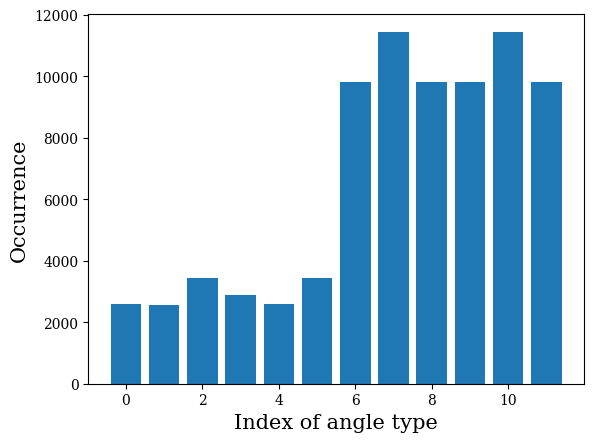

In [11]:
a_occ = plt.bar(list(at_dict.keys()),height=list(at_dict.values()))
plt.xlabel('Index of angle type',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('../Images/angles_occurr.pdf')
plt.show()

In [12]:
# One-hot encoding
labels = range(1,13)
lb = LabelBinarizer()
lb.fit(labels)

a_maxlen = int(max(lengths[:,7])/4)
Xa = torch.zeros(len(seq_data),a_maxlen*12)
for i in range(len(seq_data)):
    Xa[i,:int(lengths[i,7]/4)*12] = torch.from_numpy(lb.transform(btypes[i,:lengths[i,7].squeeze()].view(-1,4)[:,3]).reshape(-1,))
print(Xa.shape)

torch.Size([1635, 624])


PC1 variance fraction explained = 0.18054043842800613
PC2 variance fraction explained = 0.11202314767704415


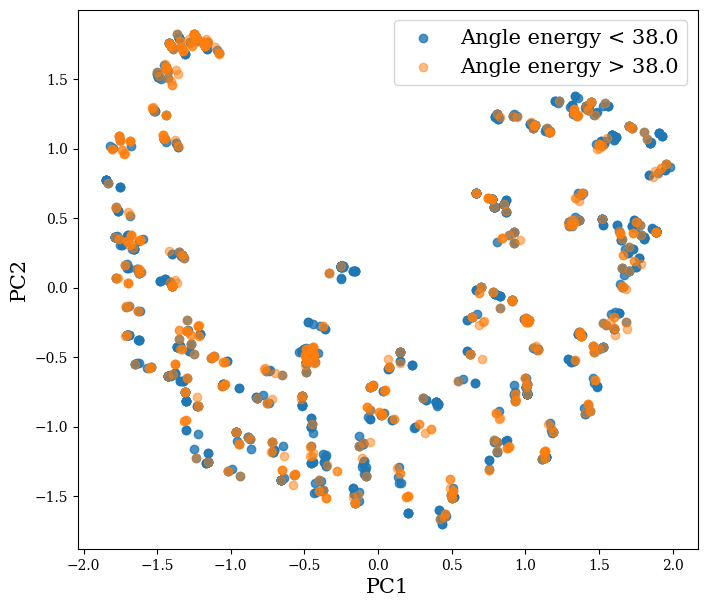

In [13]:
pca = decomposition.PCA()
Xa_pca = pca.fit_transform(Xa)
vara = pca.explained_variance_ratio_
print(f"PC1 variance fraction explained = {vara[0]}")
print(f"PC2 variance fraction explained = {vara[1]}")
fig = plt.figure(figsize=(8,7))
plt.scatter(Xa_pca[features[:,1,9]<38,0],Xa_pca[features[:,1,9]<38,1],alpha=0.8,label='Angle energy < 38.0')
plt.scatter(Xa_pca[features[:,1,9]>=38,0],Xa_pca[features[:,1,9]>=38,1],alpha=0.5,label='Angle energy > 38.0')
plt.xlabel("PC1", fontsize=15)
plt.ylabel("PC2", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('../Images/anglesPCA.pdf')
plt.show()

## Index of dihedral type

In [14]:
dt_dict = {classname: 0 for classname in np.arange(0,25)}
dtypes = features[:,:,8].squeeze().long()
for i in range(len(seq_data)):
    dt = (dtypes[i,:lengths[i,8].squeeze()]-1).view(-1,5)[:,4]
    for label in dt:
        dt_dict[label.item()] += 1
print(list(dt_dict.values()))

[3425, 3425, 2595, 2595, 2595, 3425, 2595, 2595, 3425, 2871, 2871, 2554, 2554, 2253, 2975, 2383, 2199, 9810, 9810, 9810, 11445, 9810, 9810, 9810, 9810]


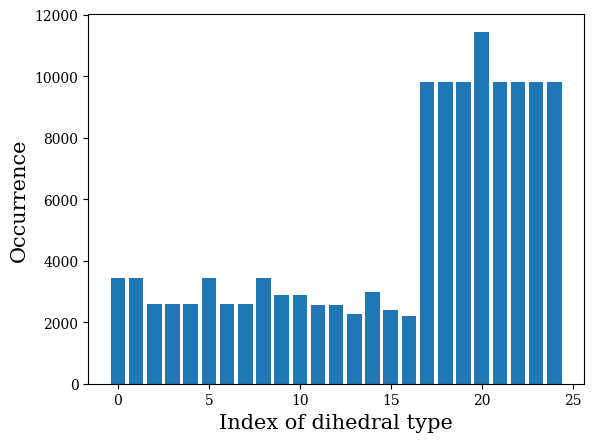

In [15]:
d_occ = plt.bar(list(dt_dict.keys()),height=list(dt_dict.values()))
plt.xlabel('Index of dihedral type',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('../Images/tors_occurr.pdf')
plt.show()

In [16]:
# One-hot encoding
labels = range(1,26)
lb = LabelBinarizer()
lb.fit(labels)

d_maxlen = int(max(lengths[:,8])/5)
Xd = torch.zeros(len(seq_data),d_maxlen*25)
for i in range(len(seq_data)):
    Xd[i,:int(lengths[i,8]/5)*25] = torch.from_numpy(lb.transform(btypes[i,:lengths[i,8].squeeze()].view(-1,5)[:,4]).reshape(-1,))
print(Xd.shape)

torch.Size([1635, 2225])


PC1 variance fraction explained = 0.22592572534417563
PC2 variance fraction explained = 0.11681821178142957


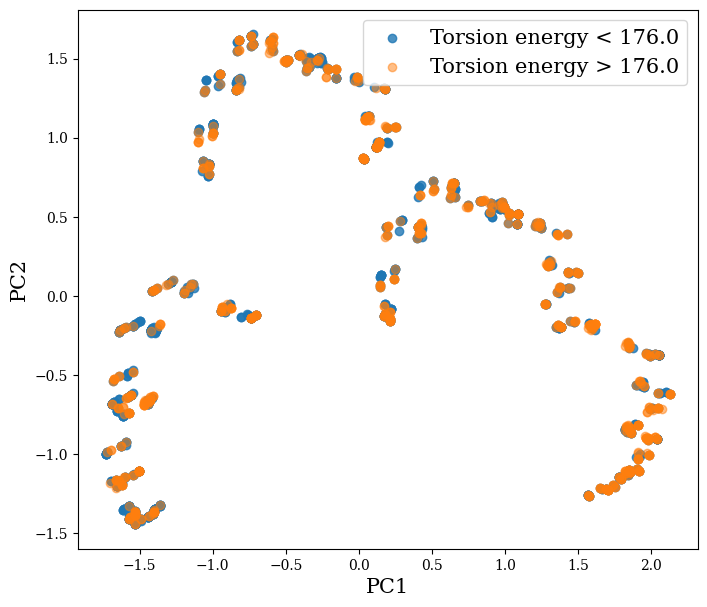

In [17]:
pca = decomposition.PCA()
Xd_pca = pca.fit_transform(Xd)
vard = pca.explained_variance_ratio_
print(f"PC1 variance fraction explained = {vard[0]}")
print(f"PC2 variance fraction explained = {vard[1]}")
fig = plt.figure(figsize=(8,7))
plt.scatter(Xd_pca[features[:,2,9]<176,0],Xd_pca[features[:,2,9]<176,1],alpha=0.8,label='Torsion energy < 176.0')
plt.scatter(Xd_pca[features[:,2,9]>=176,0],Xd_pca[features[:,2,9]>=176,1],alpha=0.5,label='Torsion energy > 176.0')
plt.xlabel("PC1", fontsize=15)
plt.ylabel("PC2", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('../Images/torsionsPCA.pdf')
plt.show()

## Index of atom type

In [18]:
atom_dict = {classname: 0 for classname in np.arange(1,12)}
atom_types = features[:,:,0].squeeze().long()
for i in range(len(seq_data)):
    att = atom_types[i,:lengths[i,0].squeeze()]
    for label in att:
        atom_dict[label.item()] += 1
print(list(atom_dict.values()))

[11445, 11445, 9810, 11445, 11445, 3425, 3425, 2595, 2595, 2554, 2871]


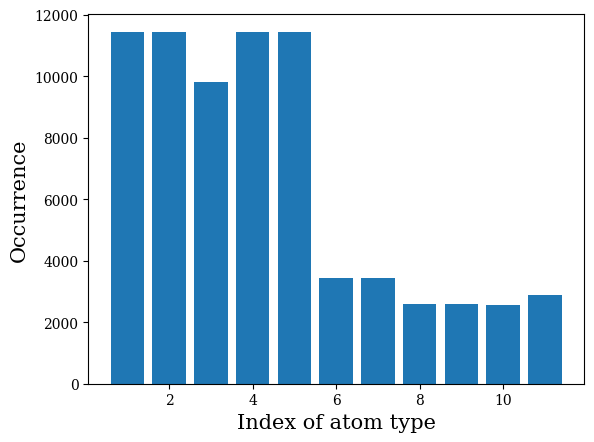

In [19]:
at_occ = plt.bar(list(atom_dict.keys()),height=list(atom_dict.values()))
plt.xlabel('Index of atom type',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('../Images/atoms_occurr.pdf')
plt.show()

## Residue type

In [7]:
res_dict = {classname: 0 for classname in np.arange(1,5)}
res_types = features[:,:,1].squeeze().long()
for i in range(len(seq_data)):
    res = res_types[i,:lengths[i,1].squeeze()]
    for label in res:
        res_dict[label.item()] += 1
print(list(res_dict.values()))

[3425, 2595, 2871, 2554]


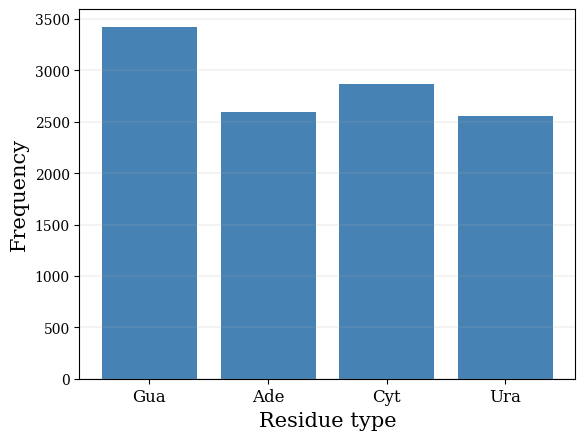

In [8]:
res_occ = plt.bar(list(res_dict.keys()),height=list(res_dict.values()),color='steelblue')
plt.xlabel('Residue type',fontsize=15, fontname='serif')
plt.ylabel('Frequency',fontsize=15, fontname='serif')
plt.xticks(list(res_dict.keys()),['Gua','Ade','Cyt','Ura'],fontsize=12, fontname='serif')
plt.grid(axis='y',linewidth=0.2)
plt.savefig('../Images/res_occurr.png', bbox_inches='tight', dpi=100)
plt.show()

## Average atom distances for each bond type (to compare with equilibrium values) and their distributions

In [22]:
def compute_distance(coords,bonds):
    
    a1 = bonds[:,0]
    a2 = bonds[:,1]
    d = coords[a1,:]-coords[a2,:]
    d = torch.linalg.norm(d, dim=1)
    
    return d



def extract_bonds(features,lengths):
    
    btypes = []
    for i in range(len(features)):
        atom = features[i,:lengths[i,0],0].squeeze().long()    
        btype = features[i,:lengths[i,6],6].squeeze().long().view(-1,3)
        btype[:,:2] = (btype[:,:2]/3).long()
        btype[:,2] -= 1    
        btypes.append(btype)
        
    return btypes



def compute_average_distance(coords,bonds):
    
    bdict = {key: [] for key in np.arange(0,11)}   
    dist_type = torch.zeros(11)
    for i in range(len(coords)):
        dist = compute_distance(coords[i],bonds[i])
        for k,d in enumerate(dist):
            key = bonds[i][k,2].item()
            bdict[key].append(d.item())
    for j in bdict.keys():
        dist_type[j] = sum(bdict[j])/len(bdict[j]) if len(bdict[j]) != 0 else 0
        
    return dist_type, bdict

In [23]:
coords = [features[i,:lengths[i,5],5].view(-1,3) for i in range(len(features))]
bonds = extract_bonds(features,lengths)
dist_type, bdict = compute_average_distance(coords,bonds)

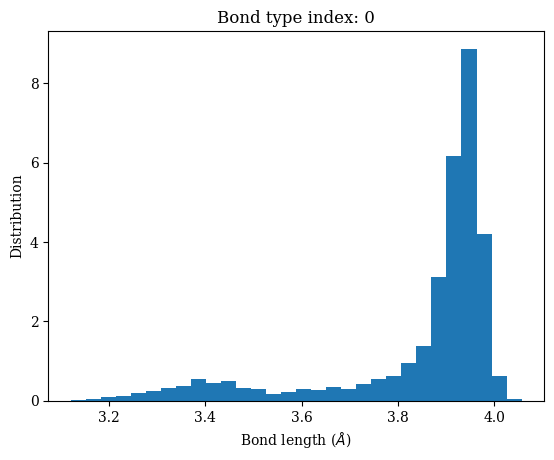

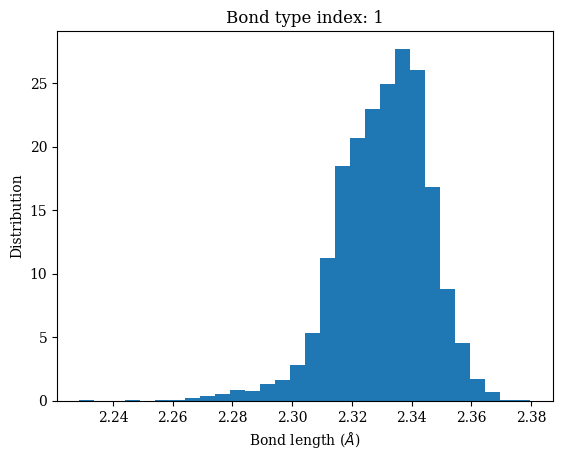

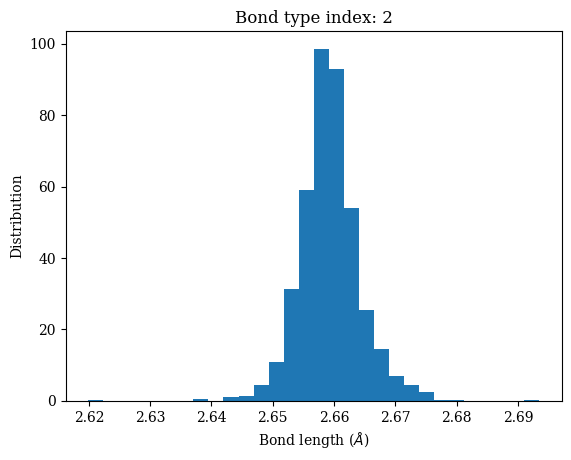

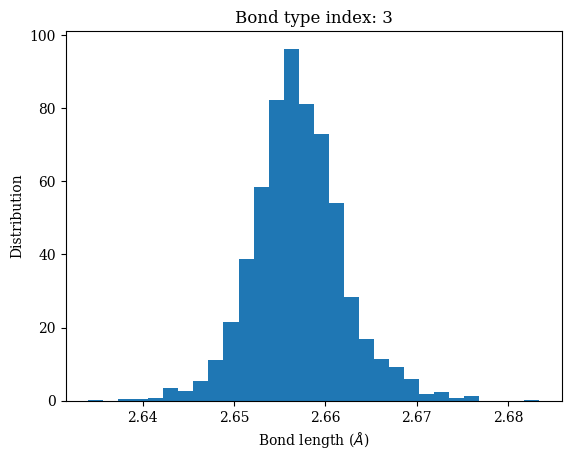

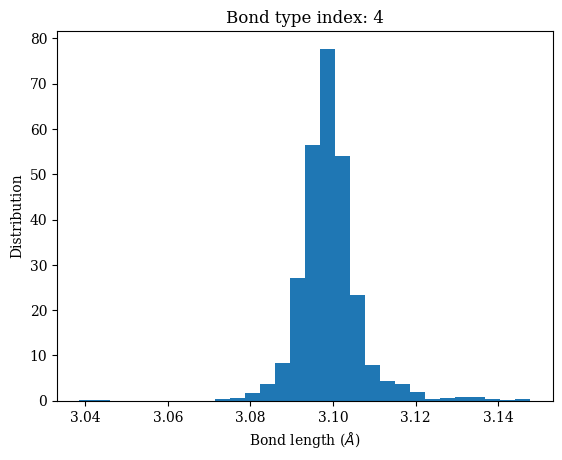

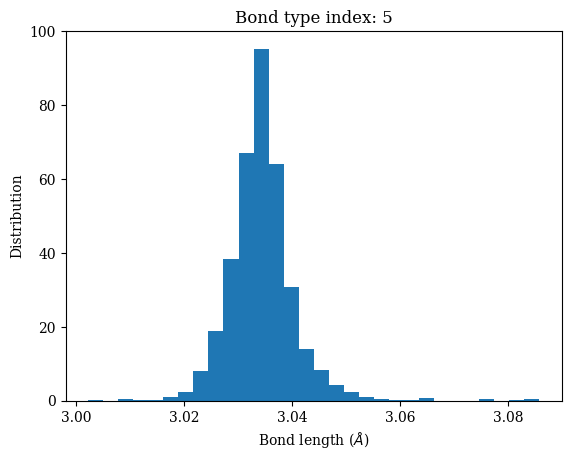

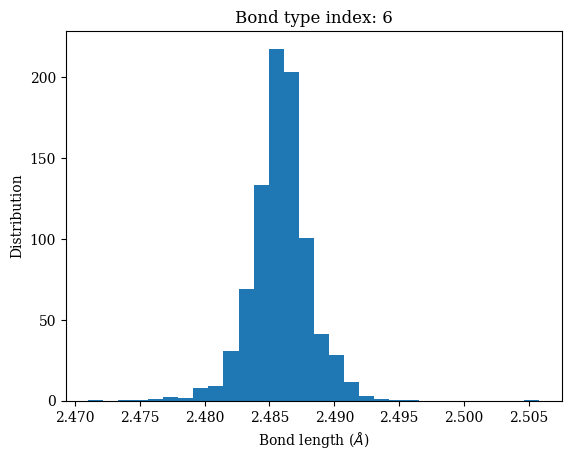

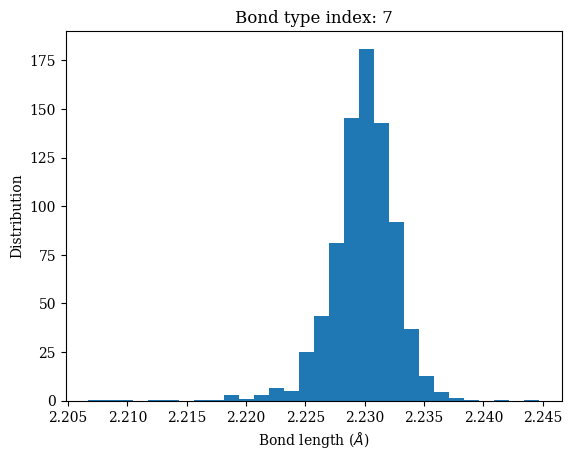

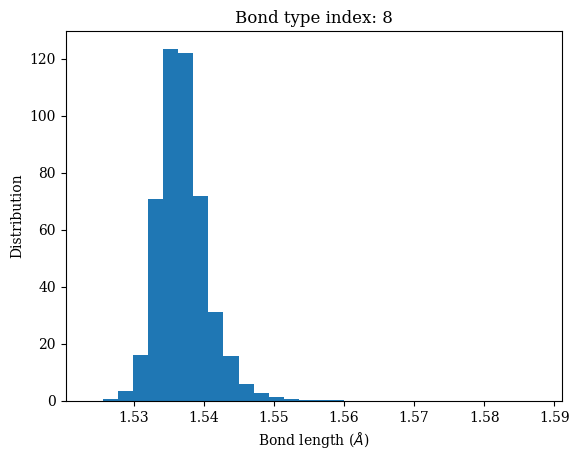

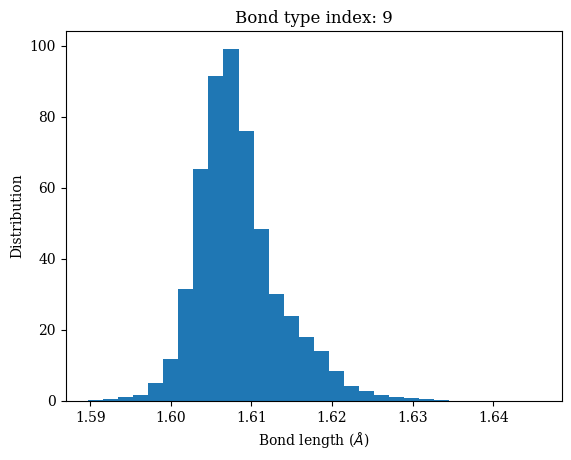

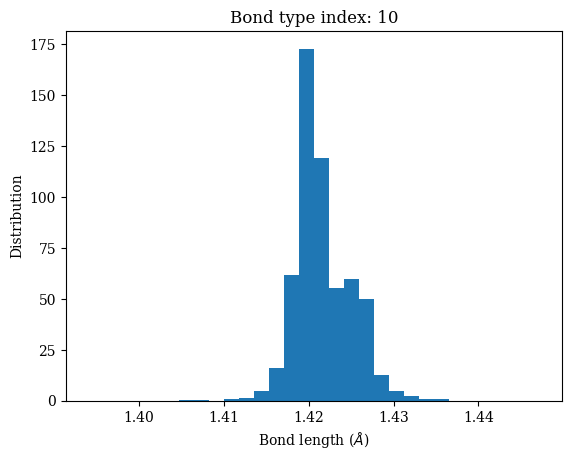

In [24]:
for j in bdict.keys():
    plt.hist(bdict[j], bins=30, density=True)
    plt.xlabel(r'Bond length ($\AA$)')
    plt.ylabel('Distribution')
    plt.title(f"Bond type index: {j}")
    plt.show()

In [25]:
print(dist_type)

model = LocalEnergyOpt()
model.load_state_dict(torch.load("../results/Results_fixedLR/initial_values_sameorder.pth"))

dist_eq = model.bond_type.data[:11,1]
print(dist_eq)

model.load_state_dict(torch.load("../results/Results_fixedLR/300_b16_e4_Aso.pth"))
dist_eq = model.bond_type.data[:11,1]
print(dist_eq)

tensor([3.8465, 2.3304, 2.6593, 2.6570, 3.0991, 3.0343, 2.4859, 2.2299, 1.5370,
        1.6085, 1.4216])
tensor([3.8000, 2.3440, 2.6220, 2.6330, 3.0620, 3.0040, 2.4500, 2.1800, 1.5200,
        1.5930, 1.4300])
tensor([3.9411, 2.1309, 2.4698, 2.7461, 3.2324, 2.6245, 2.1483, 2.2430, 1.3482,
        1.3911, 1.7229])


## Average equilibrium angle

In [26]:
def compute_angle(coords,angles):

    a1 = angles[:,0]
    a2 = angles[:,1]
    a3 = angles[:,2]
    idx = angles[:,3]

    rij = coords[a1,:] - coords[a2,:]
    rkj = coords[a3, :] - coords[a2, :]
    angle = torch.acos((rij*rkj).sum(dim=1) / (torch.linalg.norm(rij, dim=1) * torch.linalg.norm(rkj, dim=1)))
    
    return angle



def extract_angles(features,lengths):
    
    atypes = []
    # thetas = []

    for i in range(len(features)):
        # atom = features[i,:lengths[i,0],0].squeeze().long()    
        atype = features[i,:lengths[i,7],7].squeeze().long().view(-1,4)
        atype[:,:3] = (atype[:,:3]/3).long()
        atype[:,3] -= 1    
        # theta = assign_thetatype(atom,atype[:,0],atype[:,1],atype[:,2])
        atypes.append(atype)
        # thetas.append(theta)
        
    return atypes  #, thetas



def compute_average_angle(coords,angles):
    
    adict = {key: [] for key in np.arange(0,12)}   
    angle_type = torch.zeros(12)
    for i in range(len(coords)):
        angle = compute_angle(coords[i],angles[i])
        for k,a in enumerate(angle):
            key = angles[i][k,3].item()
            adict[key].append(a.item())
    for j in adict.keys():
        angle_type[j] = sum(adict[j])/len(adict[j]) if len(adict[j]) != 0 else 0
        
    return angle_type, adict

In [27]:
angles = extract_angles(features,lengths)
angle_type, adict = compute_average_angle(coords,angles)

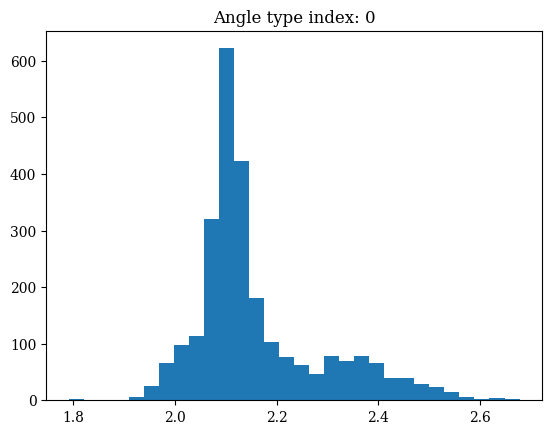

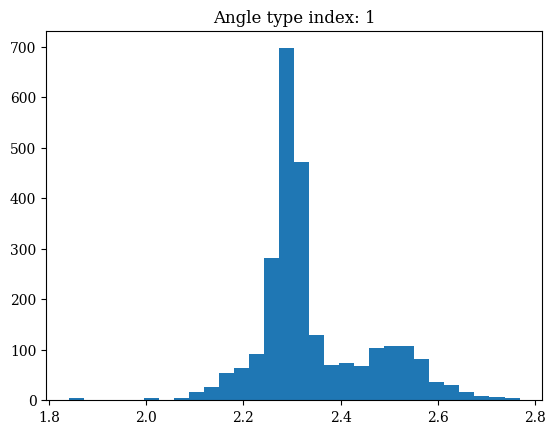

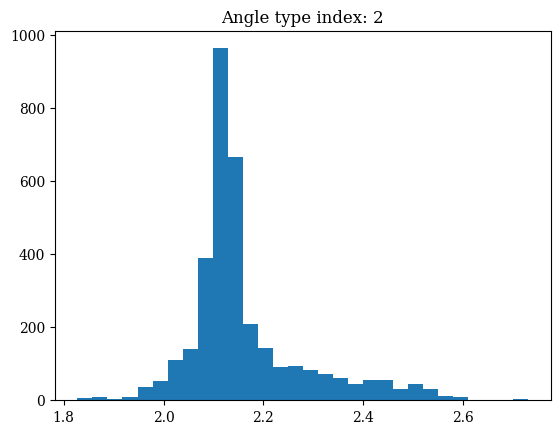

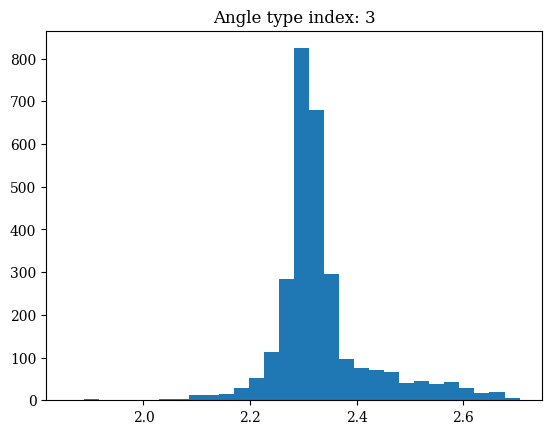

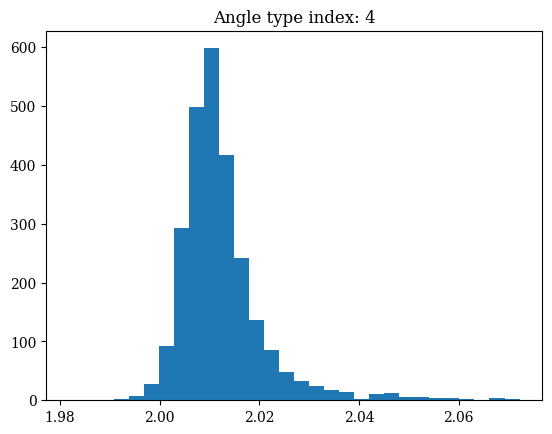

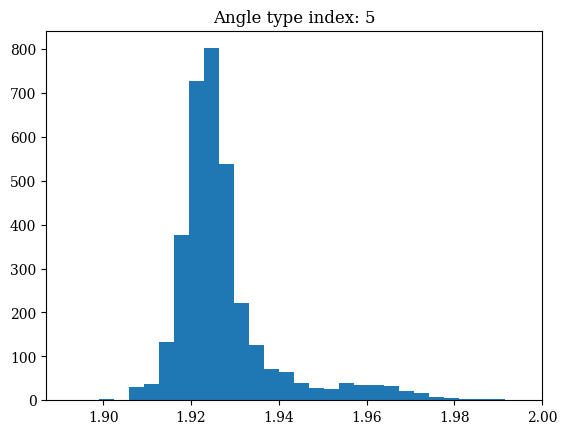

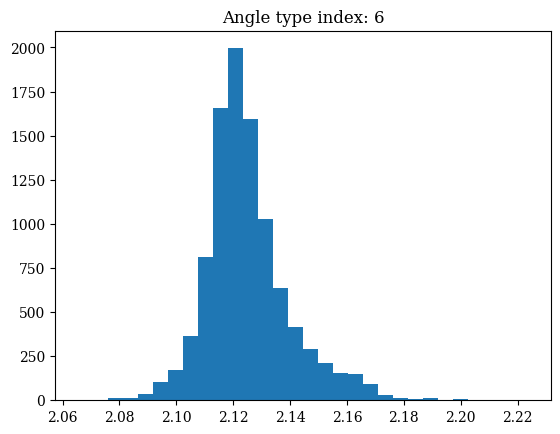

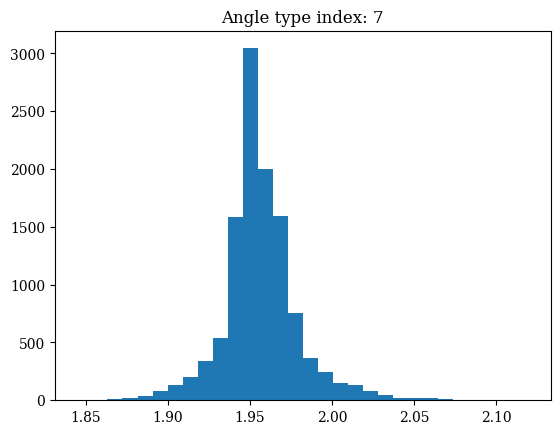

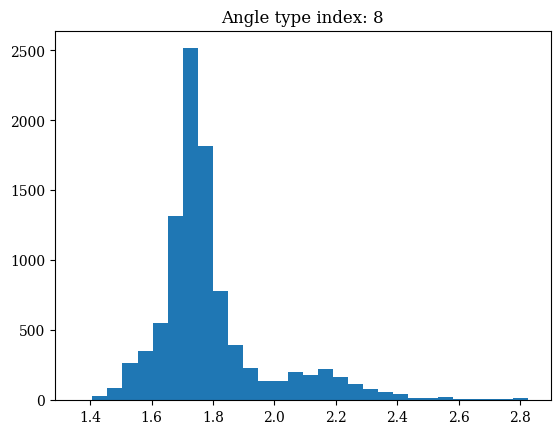

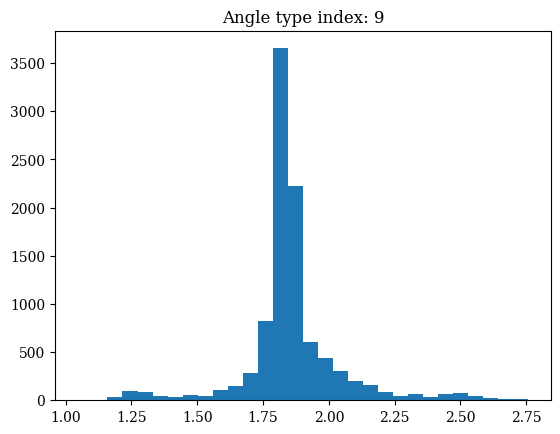

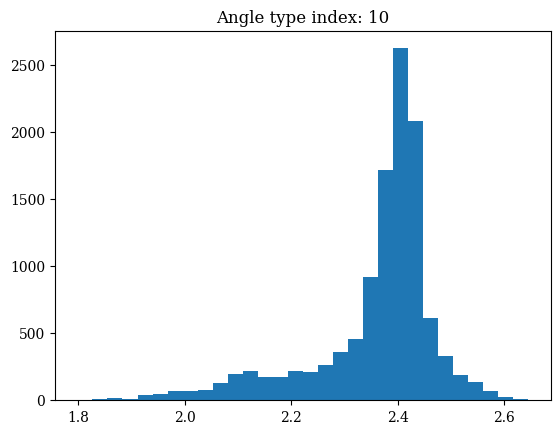

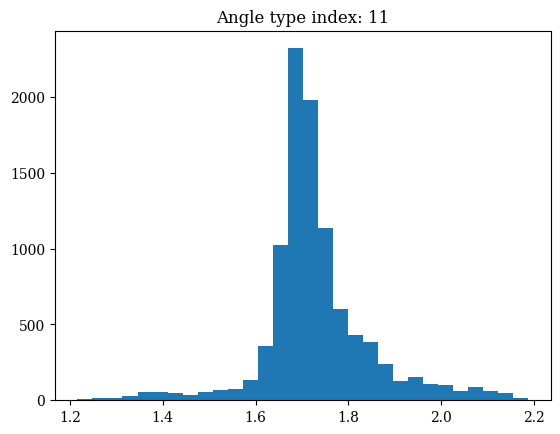

In [28]:
for j in adict.keys():
    plt.hist(adict[j], bins=30)
    plt.title(f"Angle type index: {j}")
    plt.show()

In [29]:
print(angle_type)

model.load_state_dict(torch.load("../results/Results_fixedLR/initial_values_sameorder.pth"))
angle_eq = model.angle_type.data[:12,1]
print(angle_eq)

model.load_state_dict(torch.load("../results/Results_fixedLR/300_b16_e4_Aso.pth"))
angle_eq = model.angle_type.data[:11,1]
print(angle_eq)

tensor([2.1614, 2.3433, 2.1630, 2.3339, 2.0125, 1.9274, 2.1250, 1.9563, 1.7949,
        1.8567, 2.3606, 1.7287])
tensor([2.1572, 2.3126, 2.1555, 2.2881, 2.0368, 1.9408, 2.1450, 1.9303, 1.7104,
        1.9199, 2.3649, 1.7104])
tensor([2.1223, 2.5732, 2.3958, 1.7200, 1.4761, 2.3003, 2.6192, 1.4477, 1.5727,
        2.1915, 2.0599])


## Average dihedral phase

Torsion energy is minimal if $\cos(m \varphi - \varphi_0) = -1$

In [30]:
def compute_dihedral(coords,tors,mult):
    
        a1 = tors[:,0]
        a2 = tors[:,1]
        a3 = tors[:,2]
        a4 = tors[:,3]
        idx = tors[:,4]

        rij = coords[a1,:] - coords[a2,:]
        rkj = coords[a3, :] - coords[a2, :]
        rkl = coords[a3, :] - coords[a4, :]
        nj = torch.linalg.cross(rij, rkj, dim=1)
        nj = nj / torch.linalg.norm(nj, dim=1).unsqueeze(1).expand(-1,3)
        nk = torch.linalg.cross(rkl, rkj, dim=1)
        nk = nk / torch.linalg.norm(nk,dim=1).unsqueeze(1).expand(-1,3)
        phi = torch.acos((nj*nk).sum(dim=1))
        phi = math.pi - phi*torch.sign((rkj*torch.linalg.cross(nk, nj, dim=1)).sum(dim=1))  
        phi = mult[idx]*phi + math.pi
        
        return [phase(rect(1, d)) for d in phi]   # phi  # its expectation value should be the equilibrium phase


def extract_torsions(features,lengths):
    
    ttypes = []
    # thetas = []

    for i in range(len(features)):
        # atom = features[i,:lengths[i,0],0].squeeze().long()    
        ttype = features[i,:lengths[i,8],8].squeeze().long().view(-1,5)
        ttype[:,:4] = (ttype[:,:4]/3).long()
        ttype[:,4] -= 1    
        # theta = assign_thetatype(atom,atype[:,0],atype[:,1],atype[:,2])
        ttypes.append(ttype)
        # thetas.append(theta)
        
    return ttypes  #, thetas


def mean_angle(d_list):
    return phase(sum(rect(1, d) for d in d_list)/len(d_list))


def compute_average_dihedral(coords,torsions,mult):
    
    ddict = {key: [] for key in np.arange(0,25)}   
    dihedral_type = torch.zeros(25)
    for i in range(len(coords)):
        dihedral = compute_dihedral(coords[i],torsions[i],mult)
        for k,d in enumerate(dihedral):
            key = torsions[i][k,4].item()
            ddict[key].append(d)
    for j in ddict.keys():
        dihedral_type[j] = mean_angle(ddict[j])
        
    return dihedral_type, ddict

In [31]:
mult = model.multiplicity.data
torsions = extract_torsions(features,lengths)
dihedral_type, ddict = compute_average_dihedral(coords,torsions,mult)

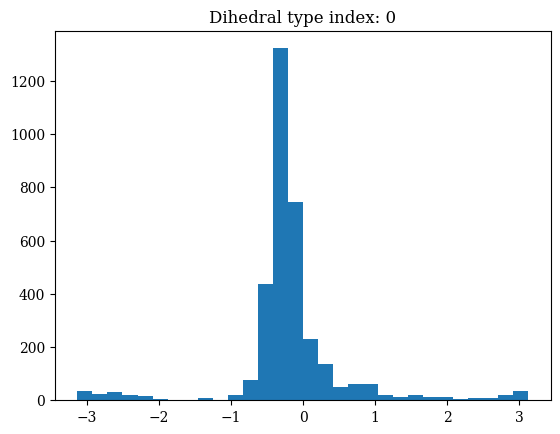

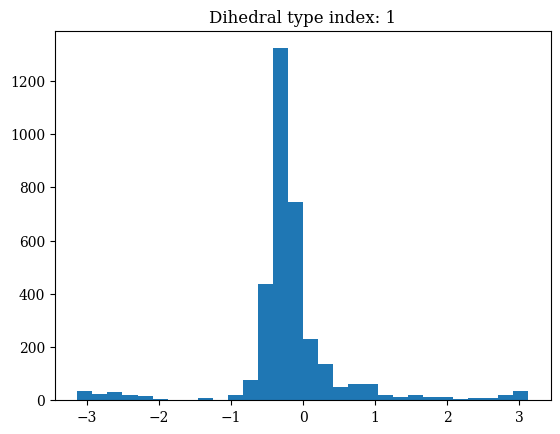

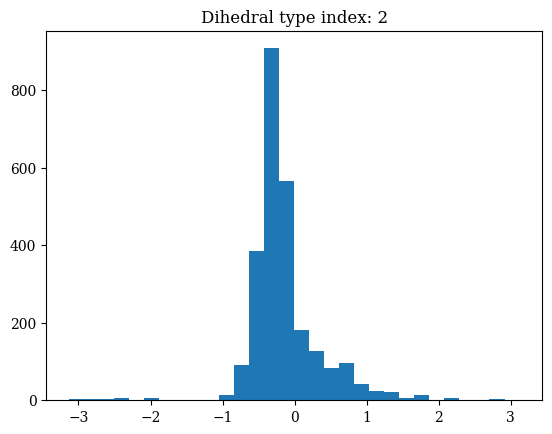

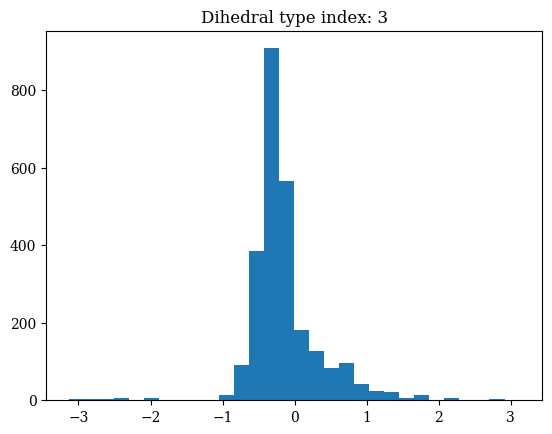

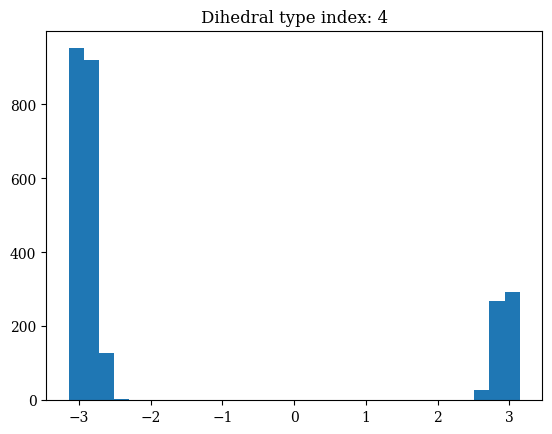

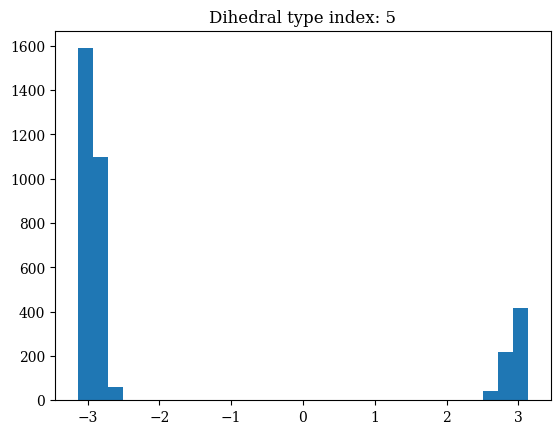

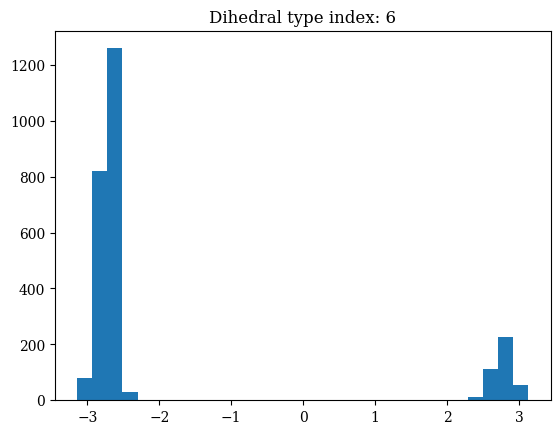

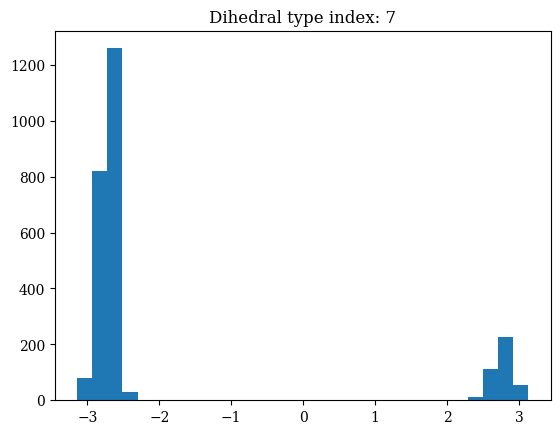

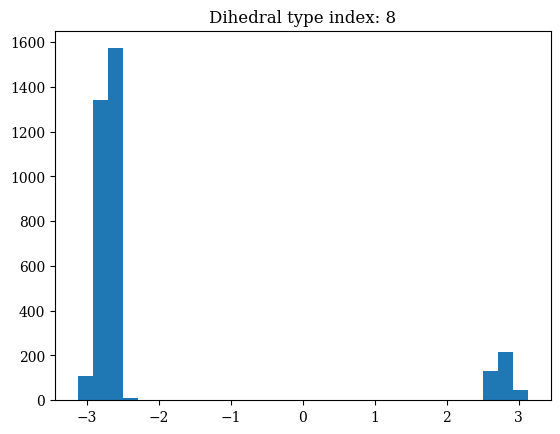

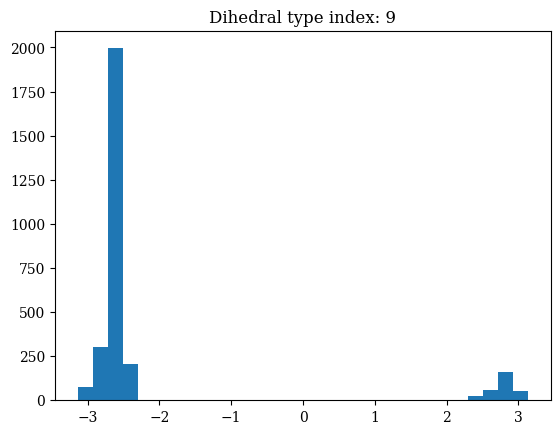

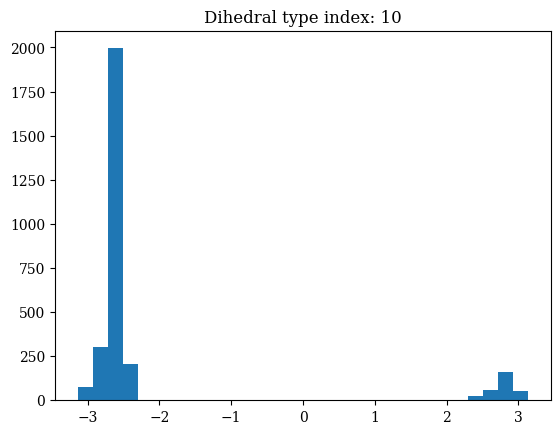

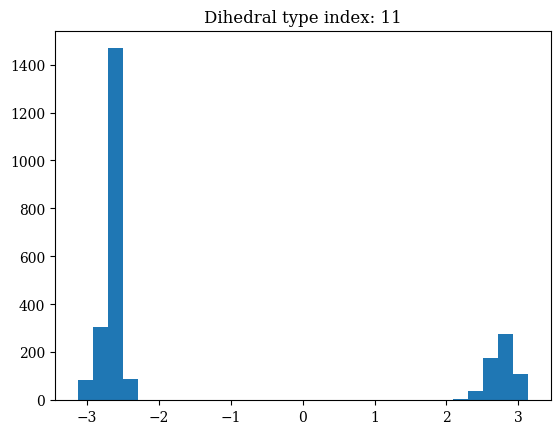

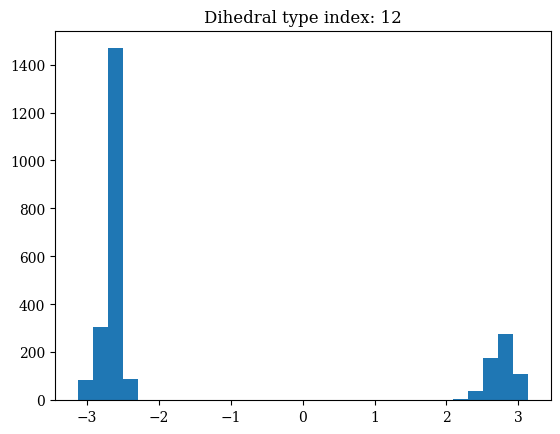

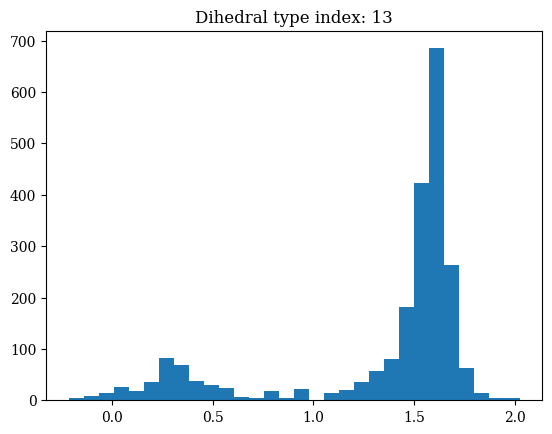

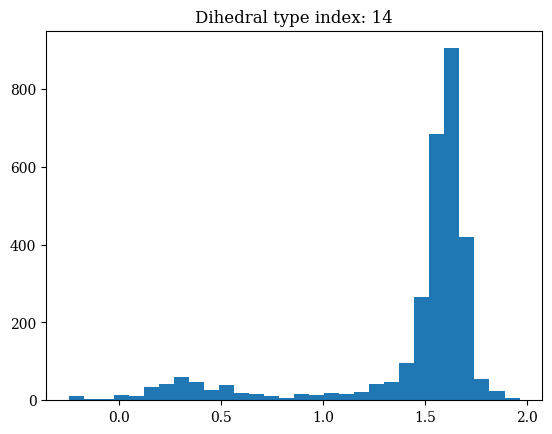

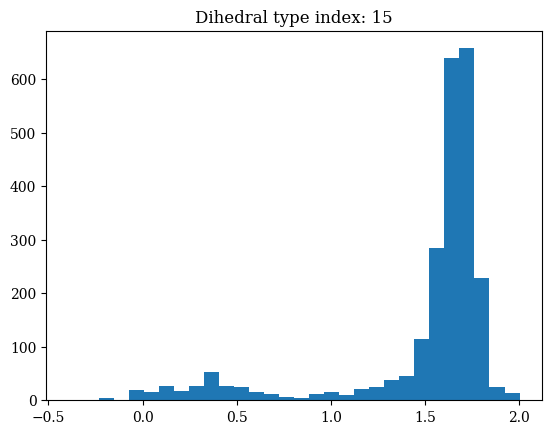

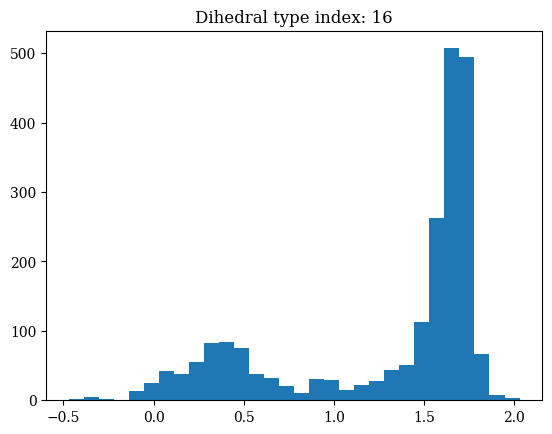

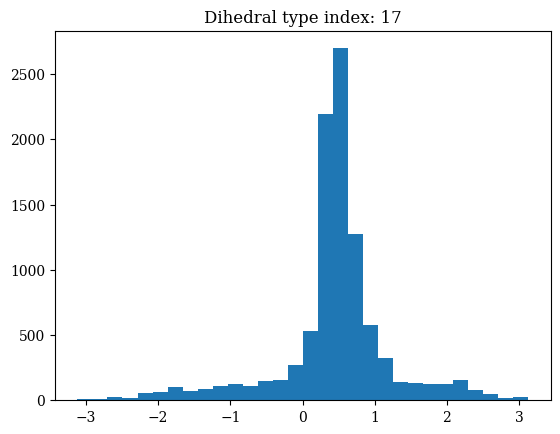

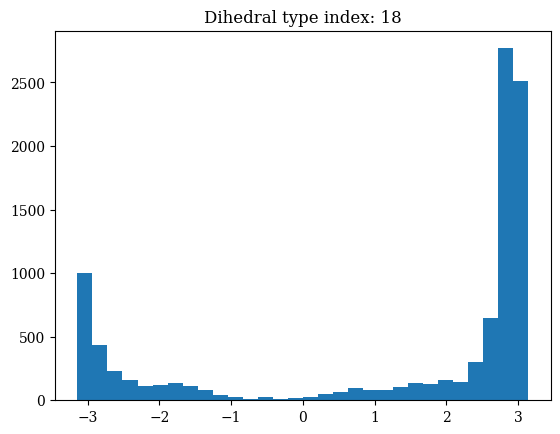

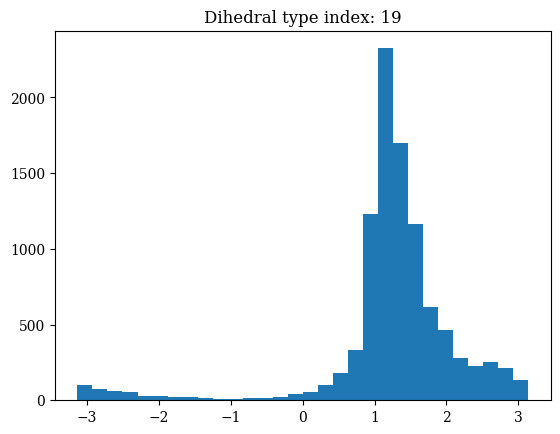

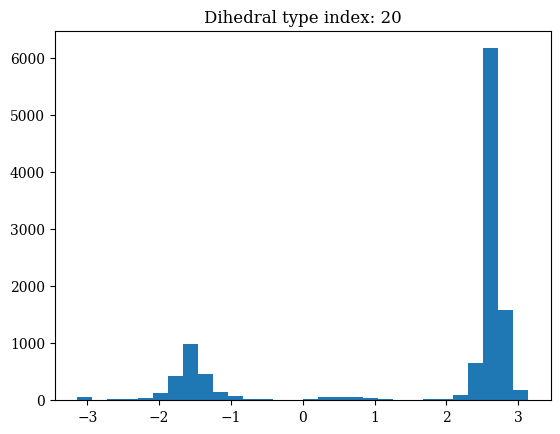

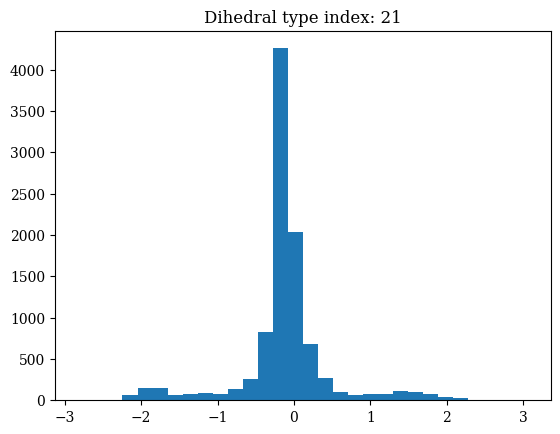

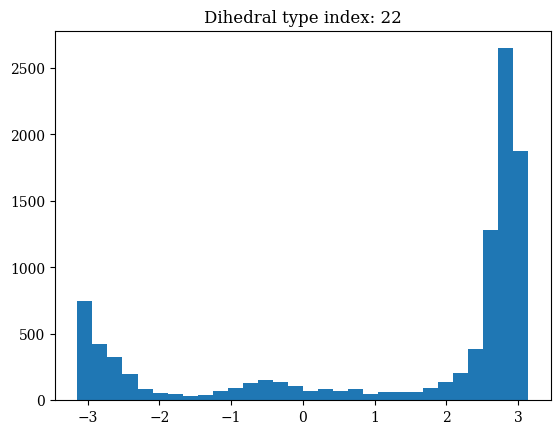

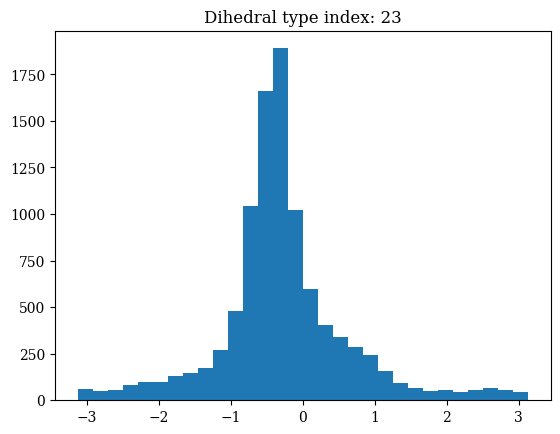

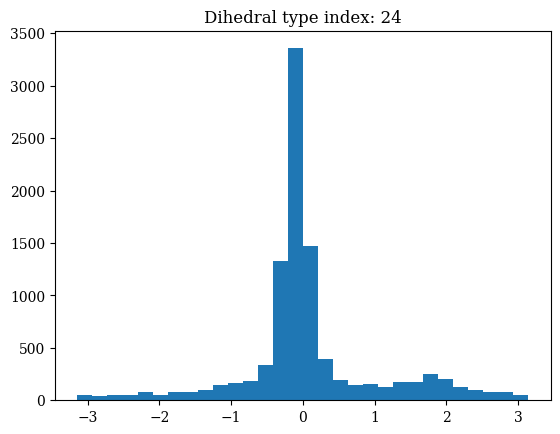

In [32]:
for j in ddict.keys():
    plt.hist(ddict[j], bins=30)
    plt.title(f"Dihedral type index: {j}")
    plt.show()

In [33]:
print("Sample average dihedral phases:")
print(dihedral_type)
print("\n")

model.load_state_dict(torch.load("../results/Results_fixedLR/initial_values_sameorder.pth"))
dihedral_eq = model.tor_type.data[:,1]
print(dihedral_eq)
cosphi = torch.cos(dihedral_type  - math.pi - dihedral_eq)  # expected to be -1
print(cosphi)
print("\n")

model.load_state_dict(torch.load("../results/Results_fixedLR/300_b16_e4_Aso.pth"))
dihedral_eq = model.tor_type.data[:,1]
print(dihedral_eq)
cosphi = torch.cos(dihedral_type  - math.pi - dihedral_eq)
print(cosphi)

Sample average dihedral phases:
tensor([-0.2048, -0.2048, -0.1592, -0.1592, -3.0179, -3.0225, -2.8342, -2.8342,
        -2.8009, -2.7143, -2.7143, -2.8432, -2.8432,  1.3839,  1.4620,  1.5300,
         1.3397,  0.4917,  2.9525,  1.4210,  2.8677, -0.1215,  2.9152, -0.3338,
        -0.0031])


tensor([-0.3491, -2.7925, -0.3491, -2.7925, -2.8798, -2.8798, -2.6180,  2.6180,
        -2.6180, -2.6180,  2.6180, -2.6180,  2.6180,  1.7453,  1.7453,  1.7453,
         1.7453,  0.3491,  2.7925,  1.5708,  2.6180,  0.0000,  3.1416,  0.0000,
         0.0000])
tensor([-0.9896,  0.8505, -0.9820,  0.8736, -0.9905, -0.9898, -0.9767, -0.6741,
        -0.9833, -0.9954, -0.5810, -0.9748, -0.6807, -0.9354, -0.9601, -0.9769,
        -0.9189, -0.9898, -0.9872, -0.9888, -0.9690, -0.9926, -0.9745, -0.9448,
        -1.0000])


tensor([-0.6879, -3.8111, -0.4356, -3.5093, -2.7435, -2.5401, -2.4006,  2.0601,
        -2.4579, -2.0087,  1.8774, -2.1825,  1.8172,  1.9180,  2.1033,  2.1984,
         2.0820, -0.8112,  1.6

# Initial HiRE energy distibution

In [10]:
import seaborn as sns

def plot_hist(idx_dict,energies):
    fig,ax = plt.subplots(1,3,figsize=(18,5))
    for i in idx_dict.keys():
        hist1 = ax[i].hist(energies['amber'][i], bins=30, density=True, label='Amber')
        ax[i].hist(energies['hire'][i], bins=30, alpha=0.6, density=True, label='HiRE')
        ax[i].set_xlabel(idx_dict[i]+' energy', fontsize=15)
        ax[i].set_ylabel('Prob. distribution', fontsize=15)
        ax[i].set_title(idx_dict[i]+' energy distribution', fontsize=18)
        ax[i].legend(fontsize=15)
    return 0


def compare_energies(dataset,model,plot=False):
    
    idx_dict = {
        0: 'Bonds',
        1: 'Angles',
        2: 'Torsions'
    }
    energies = {'amber': [], 'hire': []}
    stats = {'amber': [], 'hire': []}
    for i in idx_dict.keys():
        amber_en = np.array([dataset[j]['features'][i,9].item() for j in range(len(dataset))])
        hire_en = np.array([model(dataset[j]).squeeze()[i].item() for j in range(len(dataset))])
        energies['amber'].append(amber_en)
        energies['hire'].append(hire_en)
        stats['amber'].append([amber_en.mean(), amber_en.var()])
        stats['hire'].append([hire_en.mean(), hire_en.var()])
        print(idx_dict[i]+' energy computed')
    stats['amber'] = np.array(stats['amber'])
    stats['hire'] = np.array(stats['hire'])
    
    if plot:
        plot_hist(idx_dict,energies)
        
    return energies,stats


def amber_dist(dataset):
    idx_dict = {
        0: 'Bonds',
        1: 'Angles',
        2: 'Torsions'
    }
    energies = []
    stats = []
    for i in idx_dict.keys():
        amber_en = np.array([dataset[j]['features'][i,9].item() for j in range(len(dataset))])
        energies.append(amber_en)
        stats.append([amber_en.mean(), amber_en.var()])
    fig,ax = plt.subplots(1,3,figsize=(18,5.5))
    for i in idx_dict.keys():
        if i == 0:
            hist1 = ax[i].hist(energies[i], bins = 50, density=True, color='steelblue', lw=0)
        else:
            hist1 = ax[i].hist(energies[i], bins = 25, density=True, color='steelblue', lw=0)
        ax[i].set_xlabel(idx_dict[i]+r' energy (kcal/mol)', fontsize=16, fontname='serif')
        ax[i].set_title(idx_dict[i]+' energy distribution', fontsize=18, fontname='serif')
        ax[i].grid(linewidth=0.2)
        textstr = '\n'.join((
        r'$\mu=%.2f$' % (stats[i][0], ),
        r'$\sigma=%.2f$' % (stats[i][1]**0.5, )))

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)

        # place a text box in upper left in axes coords
        ax[i].text(0.65, 0.9, textstr, transform=ax[i].transAxes, fontsize=16,
                verticalalignment='top', bbox=props, fontname='serif')
        
    ax[0].set_ylabel('Prob. distribution', fontsize=16, fontname='serif')
    ax[0].set_xlim([5,30])
    plt.savefig('Images/amber_histo.png', bbox_inches='tight', dpi=100)
    return energies,stats


def amber_dist_oneplot(dataset):
    idx_dict = {
        0: 'Bonds',
        1: 'Angles',
        2: 'Torsions'
    }
    energies = []
    stats = []
    for i in idx_dict.keys():
        amber_en = np.array([dataset[j]['features'][i,9].item() for j in range(len(dataset))])
        energies.append(amber_en)
        stats.append([amber_en.mean(), amber_en.var()])
    fig,axes = plt.subplots(1,3,figsize=(18,5.5))
    for i in idx_dict.keys():
        sns.distplot(ax = axes[i], x=energies[i], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3})
        axes[i].set_xlabel(idx_dict[i]+r' energy (kcal/mol)', fontsize=16, fontname='serif')
        axes[i].set_title(idx_dict[i]+' energy distribution', fontsize=18, fontname='serif')
        axes[i].grid(linewidth=0.2)
        textstr = '\n'.join((
        r'$\mu=%.2f$' % (stats[i][0], ),
        r'$\sigma=%.2f$' % (stats[i][1]**0.5, )))

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)

        # place a text box in upper left in axes coords
        axes[i].text(0.65, 0.9, textstr, transform=axes[i].transAxes, fontsize=16,
                verticalalignment='top', bbox=props, fontname='serif')
        
    axes[0].set_ylabel('Prob. distribution', fontsize=16, fontname='serif')
    axes[0].set_xlim([5,30])
    plt.savefig('Images/amber_dist.png', bbox_inches='tight')
    return energies,stats
    

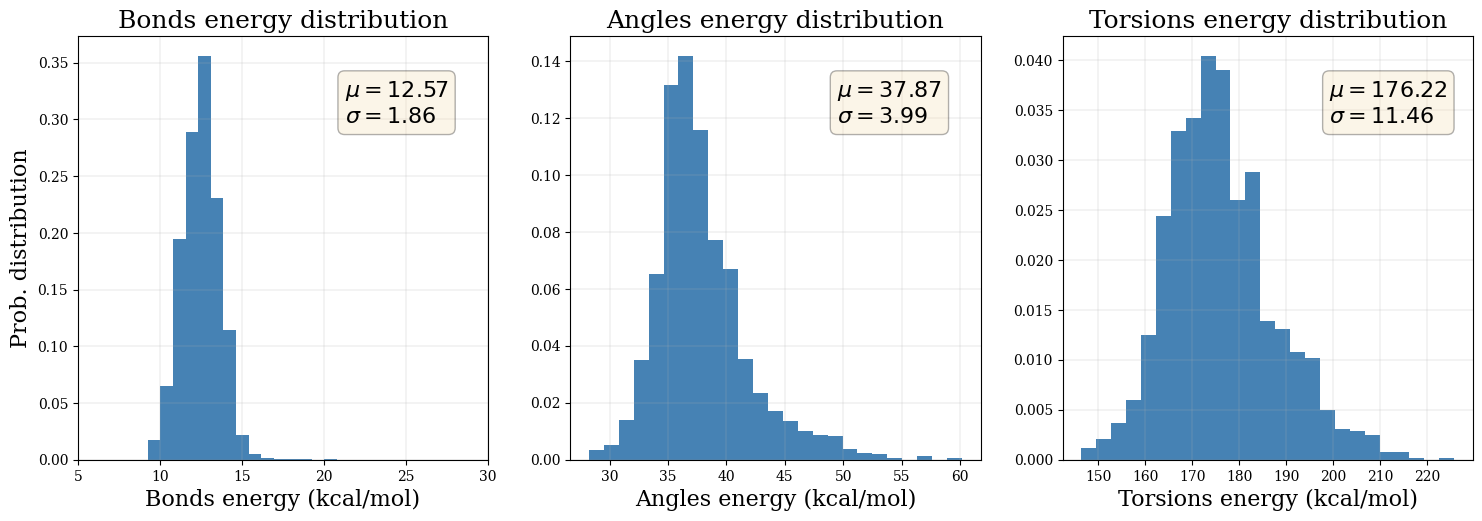

In [11]:
dataset = RNASeqDataset()
energies, stats = amber_dist(dataset)

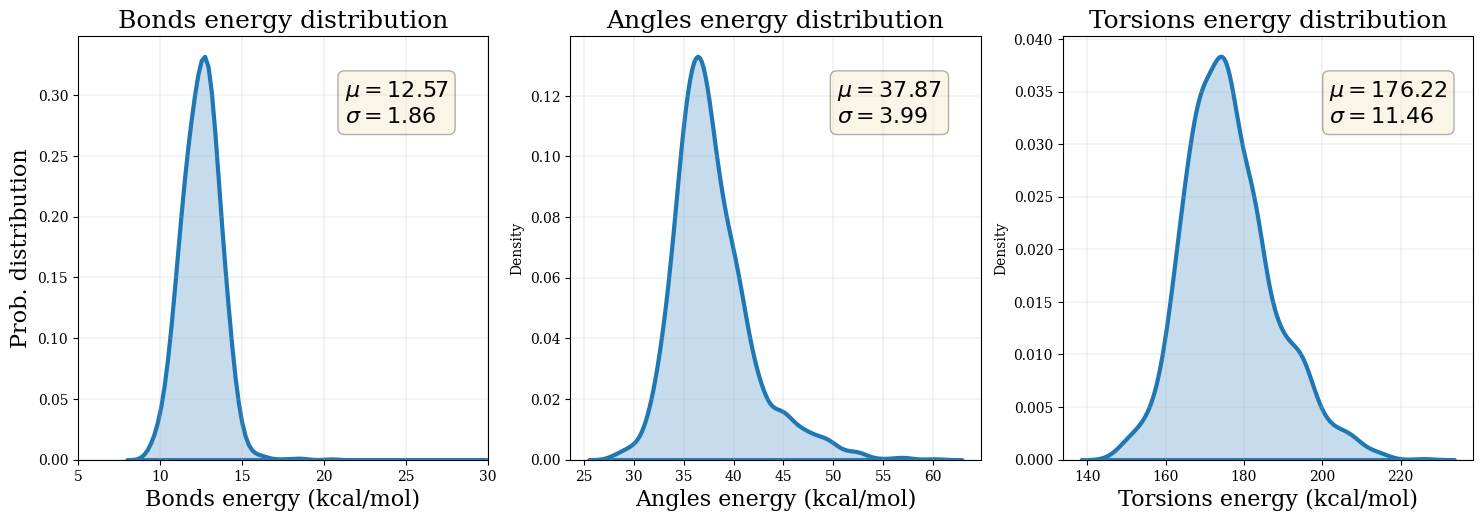

In [70]:
energies,stats = amber_dist_oneplot(dataset)

In [36]:
print(stats)

[[12.565882105929406, 3.4582106369510317], [37.86977778093531, 15.898139077976227], [176.21871348156478, 131.38891481996774]]


Bonds energy computed
Angles energy computed
Torsions energy computed


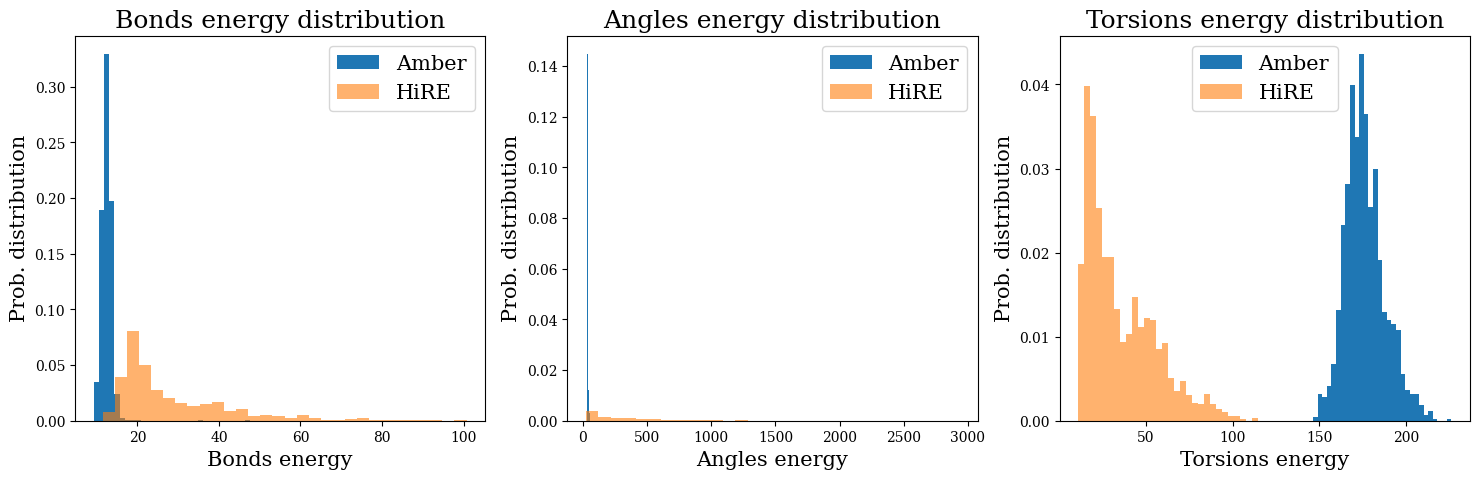

In [37]:
model = LocalEnergyOpt()
dataset = RNASeqDataset()
model.load_state_dict(torch.load("../results/Results_fixedLR/initial_values.pth"))
energies, stats = compare_energies(dataset,model,plot=True)